<a href="https://colab.research.google.com/github/shirshmohan/Kidney-Stone-Classfication-Project/blob/main/VGG16_kidney_stone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D



from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')

check


In [ ]:
import pandas as pd
import numpy as n

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = '/content/drive/MyDrive/Kidney_Dataset/Kidney_Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
categories = ["Cyst", "Normal", "Stone", "Tumor"]

In [ ]:
import pandas as pd
import numpy as np
import os

# Correcting the base_path as it appears to have a redundant directory segment
base_path = '/content/drive/MyDrive/Kidney_Dataset/Kidney_Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

In [ ]:
df.tail()

,image_path,label
12444,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Tumor
12445,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Tumor
12446,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Tumor
12447,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Tumor
12448,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Tumor


In [ ]:
df.shape

(12446, 2)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

df = df[['image_path', 'category_encoded']]

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df['category_encoded']
)


valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df['category_encoded']
)

ros = RandomOverSampler(random_state=42)


X_train_resampled, y_train_resampled = ros.fit_resample(
    train_df[['image_path']],
    train_df['category_encoded']
)


train_df_balanced = pd.DataFrame(X_train_resampled, columns=['image_path'])
train_df_balanced['category_encoded'] = y_train_resampled

print("Balanced Training Set Counts:\n", train_df_balanced['category_encoded'].value_counts())
print("\nOriginal (Imbalanced) Test Set Counts:\n", test_df['category_encoded'].value_counts())

Balanced Training Set Counts:
 category_encoded
1    4061
0    4061
2    4061
3    4061
Name: count, dtype: int64

Original (Imbalanced) Test Set Counts:
 category_encoded
1    508
0    371
3    228
2    138
Name: count, dtype: int64


In [ ]:
train_df_balanced['category_encoded'] = train_df_balanced['category_encoded'].astype(str)
test_df['category_encoded'] = test_df['category_encoded'].astype(str)


In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_balanced,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 16244 validated image filenames belonging to 4 classes.


In [ ]:
train_df_balanced['category_encoded'] = train_df_balanced['category_encoded'].astype(str)
valid_df['category_encoded'] = valid_df['category_encoded'].astype(str)
test_df['category_encoded'] = test_df['category_encoded'].astype(str)

In [ ]:
valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 1245 validated image filenames belonging to 4 classes.
Found 1245 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# 1. Load base model with consistent input shape
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3), # Matched to your other models
    pooling='avg',             # 'avg' often works better than 'max' for medical textures
    weights='imagenet'
)

# 2. Freeze the base model immediately
pretrained_model.trainable = False

# 3. Build the top head
VGG_model = tf.keras.Sequential([
    pretrained_model,
    # No Flatten() needed if pooling is 'avg' or 'max'
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
], name="VGG16_Transfer_Model")



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 4. Compile
VGG_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
VGG_model.summary()

Model: "VGG16_Transfer_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,981,444 (57.15 MB)

 Trainable params: 265,732 (1.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [ ]:
epochs=5

checkpoint = ModelCheckpoint(
    'best_vgg_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
history = VGG_model.fit(
  train_gen_new,
  validation_data=valid_gen_new,
  epochs=epochs
)

Epoch 1/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 4434s 4s/step - accuracy: 0.5659 - loss: 1.0523 - val_accuracy: 0.8289 - val_loss: 0.4502
Epoch 2/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 130s 128ms/step - accuracy: 0.8291 - loss: 0.4613 - val_accuracy: 0.9406 - val_loss: 0.1993
Epoch 3/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 129s 126ms/step - accuracy: 0.8895 - loss: 0.3135 - val_accuracy: 0.9574 - val_loss: 0.1448
Epoch 4/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 130s 128ms/step - accuracy: 0.9128 - loss: 0.2436 - val_accuracy: 0.9735 - val_loss: 0.1175
Epoch 5/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 133s 131ms/step - accuracy: 0.9350 - loss: 0.1920 - val_accuracy: 0.9847 - val_loss: 0.0746


In [ ]:
import shutil
VGG_model.save('best_vgg_model.keras')

shutil.copy('best_vgg_model.keras', '/content/drive/MyDrive/VGG_model')

'/content/drive/MyDrive/VGG_model/best_vgg_model.keras'

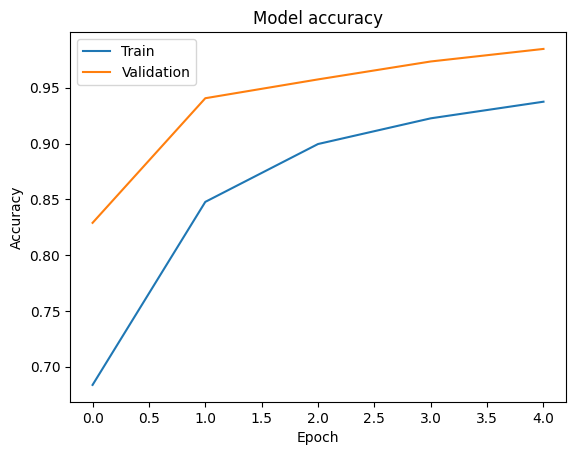

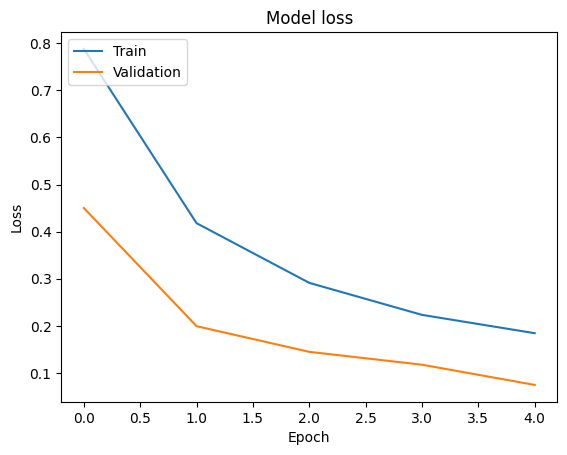

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_gen_new.classes
predictions = VGG_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 482s 6s/step


In [ ]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       371
           1       0.97      0.99      0.98       508
           2       0.98      0.97      0.97       138
           3       1.00      0.95      0.97       228

    accuracy                           0.98      1245
   macro avg       0.98      0.97      0.98      1245
weighted avg       0.98      0.98      0.98      1245



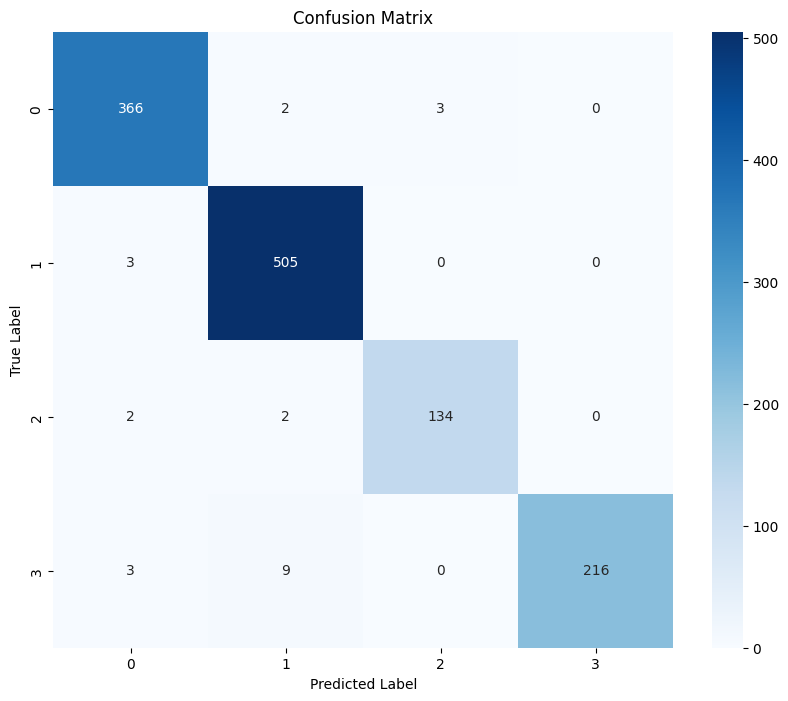

In [ ]:
import seaborn as sns
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()